In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#create engine using the hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#declare a base
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(engine,reflect=True)

# reflect the tables
Base.classes.keys()
# We can view all of the classes that automap found

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (data and prcp)
last_row = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
for row in last_row:
    print(f'Last record was: {row}')
    

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

Last record was: 2017-08-23
Last record was: 0.0


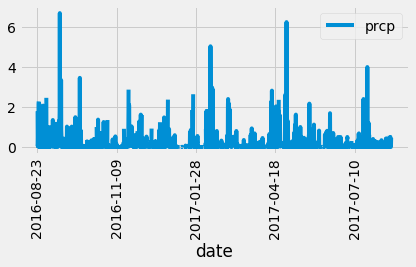

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year, columns=['date','prcp'])
            #dropping null and zero values - not needed
            # last_year_df = last_year_df[last_year_df != 0]
            # last_year_df = last_year_df.dropna(how='any')

last_year_df.set_index('date',inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values('date')
last_year_df

#Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
all_stations = session.query(Measurement.station).group_by(Measurement.station).all()
count_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(all_stations)
print(f'There are a total of {count_stations} stations')

[('USC00511918',), ('USC00513117',), ('USC00514830',), ('USC00516128',), ('USC00517948',), ('USC00518838',), ('USC00519281',), ('USC00519397',), ('USC00519523',)]
There are a total of 9 stations


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# average temperature of the most active station?
most_active = station_count[0][0]
low_hi_avg = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == most_active).all()
low_hi_avg    

[(54.0, 71.66378066378067, 85.0)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= '2016-08-23').all()
most_active_tobs_df = pd.DataFrame(most_active_results)
most_active_tobs_df.set_index('station', inplace=True)
most_active_tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

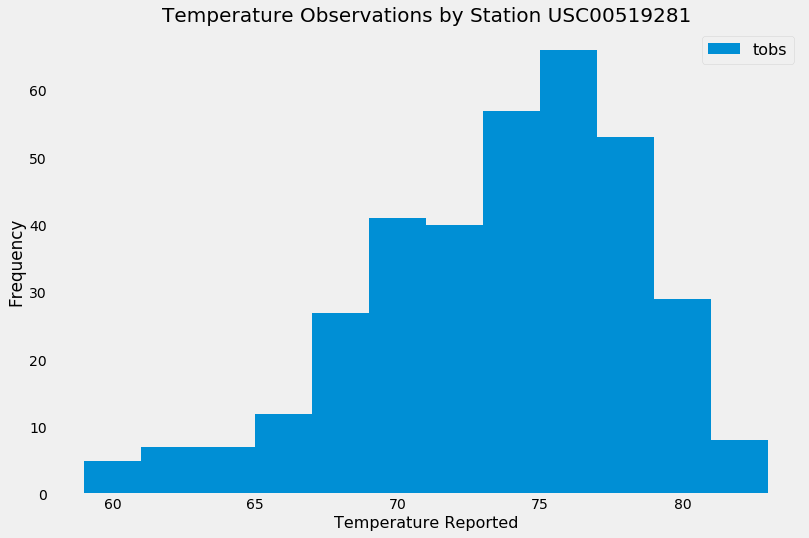

In [17]:
most_active_tobs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations by Station " + most_active, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
#plt.savefig("Output/StationTemps.png")
plt.show

## Step 2 - Climate App

Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.



* Use Flask to create your routes.

### Routes

* `/`

  * Home page.

  * List all routes that are available.

* `/api/v1.0/precipitation`

  * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`
  * Query the dates and temperature observations of the most active station for the last year of data.
  
  * Return a JSON list of temperature observations (TOBS) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the queries.

* Use Flask `jsonify` to convert your API data into a valid JSON response object.

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
